In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import numpy as np
import pickle

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from sklearn.decomposition import PCA
import sys
sys.path.append('/home/icb/manuel.gander/Atl/notebooks/')
import utils
import importlib
utils = importlib.reload(utils)

In [6]:
def run_weighted_als(X,W,l,iterations,regularization, X0='rnd', Y0='rnd', seed=0):
    n0,n1=X.shape
    #X=torch.tensor(X).to_gpu()
    #W=torch.tensor(W).to_gpu()
    
    if str(type(X0))=="<class 'str'>" and str(type(Y0))=="<class 'str'>":
        np.random.seed(seed)
        X1=np.zeros((l,n0))
        Y0=np.random.rand(l,n1)
        Y1=np.zeros((l,n1))
    elif str(type(X0))=="<class 'str'>" or str(type(Y0))=="<class 'str'>":
        print('Please provide both X0 and Y0')
    else:
        X1=np.zeros((l,n0))
        Y1=np.zeros((l,n1))
        
    
    X=torch.tensor(X).cuda().float()
    W=torch.tensor(W).cuda().float()
    Y0=torch.tensor(Y0).cuda().float()
    
    
    for k in range(iterations):
        X0=iterate_gpu(n0, X, W, Y0, l, regularization, 0)
        Y0=iterate_gpu(n1, X, W, X0, l, regularization, 1)
    X0=X0.cpu().numpy()
    Y0=Y0.cpu().numpy()
        
    return(X0,Y0)

# All of them should be tensors
def iterate_gpu(n0, X, W, Y0, l, regularization, pos):
    X1=torch.zeros((l,n0)).cuda()
    l0=regularization*torch.diag(torch.ones(l)).cuda()
    for i in range(n0):
        #print(i)
        if pos==0:
            cd=W[i,:]
            pd=X[i,:]
        elif pos==1:
            cd=W[:,i]
            pd=X[:,i]
        
        cY0T=Y0.T * cd[:, np.newaxis]
        M=torch.matmul(Y0,cY0T)+l0
        b=torch.matmul(Y0,pd*cd)
        X1[:,i]=torch.linalg.solve(M,b)
    return(X1)

In [7]:
Path = '/home/icb/manuel.gander/Atl/data'

In [8]:
# Take a drug representation (e.g. ALS, Kinobeads, rdkit ) 
# and the cell line encoding (prob. PCA, maybe picked features)
# and do a shallow NN to predict curves

## Kinobead data

In [9]:
V = pd.read_pickle(f'{Path}/Kinobead_V.pkl')
v_kinases = list(V.columns)[:-4]
vs = V[v_kinases].sum(0)
v_kinases = list(vs[vs>5].index)
V['log_dose']=np.log10(V['Dose'])
drugs = sorted(set(V['PubChem_CID']))

In [10]:
len(drugs)

106

## Feature data

In [11]:
dataset = 'RNA'
dataset = 'identity'
dataset = 'atl_only_full'
dataset = 'atl_only_phos'
n_components = 10

with open(f'/home/icb/manuel.gander/Atl/data/pcas/{dataset}_{n_components}.pkl', 'rb') as file:
    D_prot2, features, cellos = pickle.load(file)

## Viability data (AUCs)

In [12]:
# We need this to already remove cell lines that are used for testing

In [13]:
dfv=pd.read_pickle(f"{Path}/Synched_aucs.pkl")
dfv = dfv[dfv['Source']!='PRISM2'].copy()
dfv=dfv[np.isfinite(dfv['AUC'])].copy()
dfv = dfv[dfv['PubChem_CID'].isin(drugs)].copy()

# Only keep cell lines for which we have at least 5 drugs
dfv = dfv[dfv['Cello'].isin(cellos)].copy()
vc = dfv[['Cello', 'PubChem_CID']].drop_duplicates().value_counts('Cello')
ccls = list(vc[vc>5].index)
dfv = dfv[dfv['Cello'].isin(ccls)].copy()

dfv

,PubChem_CID,Cello,Source,AUC,ic50,min_dose,max_dose,Dr_repr_name
3059,10029385,786O,DTP,0.748423,0.749486,-32,10,LY2090314
3060,10029385,A498,DTP,0.763912,1.166008,-32,10,LY2090314
3061,10029385,A549,DTP,0.932627,1.415040,-32,10,LY2090314
3062,10029385,ACHN,DTP,0.766117,0.808155,-32,10,LY2090314
3063,10029385,BT549,DTP,0.931105,1.754568,-32,10,LY2090314
...,...,...,...,...,...,...,...,...
2401787,9849735,TK10,MR_NCI60,0.740540,1.144140,-30,12,Sonolisib
2401788,9849735,U251MG,MR_NCI60,0.806685,1.133950,-30,12,Sonolisib
2401789,9849735,UACC257,MR_NCI60,0.815633,1.371880,-30,12,Sonolisib
2401790,9849735,UACC62,MR_NCI60,0.667041,0.018763,-30,12,Sonolisib


## Define holdout set

In [14]:
# Split into train and test set
fr_ccls=0.2

test_ccls = np.random.choice(sorted(set(dfv['Cello'])), int(len(sorted(set(dfv['Cello'])))*fr_ccls), replace=False)
train_ccls = [a for a in sorted(set(dfv['Cello'])) if not a in test_ccls]

In [15]:
len(test_ccls)

17

In [17]:
len(set(dfv['Cello']))

86

In [16]:
#dfv_test = dfv[dfv['Cello'].isin(test_ccls)].copy()
#dfv_train = dfv[dfv['Cello'].isin(train_ccls)].copy()

# Compute ALS representation

In [13]:
Path = '/home/icb/manuel.gander/Atl/data'
dfv2 = pd.read_pickle(f'{Path}/Synched_aucs.pkl')
dfv2 = dfv2[np.isfinite(dfv2['AUC'])].copy()
dfv2 = dfv2[np.isfinite(dfv2['ic50'])].copy()
# Make max ic50 to be max dose
dfv2.loc[dfv2['ic50']>dfv2['max_dose']/10, 'ic50'] = dfv2.loc[dfv2['ic50']>dfv2['max_dose']/10]['max_dose']/10

In [134]:
renormalize=True
#renormalize=False
# Renormalize, i.e. divide by curve front
import pickle
# Load from pickle file
with open(f'{Path}/Fits.pkl', 'rb') as file:
    F = pickle.load(file)
    
D_F={}
for s in F.keys():
    D_F[s]={}
    Df = F[s]
    
    ccls = [a.split('_')[0] for a in Df.index]
    Df['Cello']=ccls
    drugs = [a.split('_')[1] for a in Df.index]
    Df['PubChem_CID']=drugs

    drugs = sorted(set(Df.PubChem_CID))
    
    for d, Dfs in list(Df.groupby('PubChem_CID')):
        D_F[s][d]={}
        ccls = list(Dfs['Cello'])
        fronts = list(Dfs['front'])
        for i in range(len(Dfs)):
            D_F[s][d][ccls[i]]=fronts[i]
ccls = list(dfv2['Cello'])
drugs = list(dfv2['PubChem_CID'])
sources = list(dfv2['Source'])

fronts = []
for i in range(len(dfv2)):
    fronts.append(D_F[sources[i]].get(drugs[i], {}).get(ccls[i], np.NaN))
dfv2['fronts']=fronts
dfv2 = dfv2[np.isfinite(dfv2['fronts'])].copy()
if renormalize:
    dfv2['AUC']=dfv2['AUC']/dfv2['fronts']
# Filter out abstruse AUCs
dfv2 = dfv2[dfv2['AUC'].between(-0.5, 1.5)].copy()

In [135]:
dfv2s = dfv2[['PubChem_CID', 'Cello', 'AUC', 'ic50']].groupby(['PubChem_CID', 'Cello']).mean().reset_index().copy()
dfv2s.index= range(len(dfv2s))

In [136]:
dfvs = dfv2s[dfv2s['Cello'].isin(train_ccls)].copy()

In [137]:
drugs = sorted(set(dfv2s['PubChem_CID']))
ccls = sorted(set(dfv2s['Cello']))

In [138]:
vals = 'dAUC'

# Filter out cell lines with less than n_min drugs and drugs with less than n_min cell lines
n_min = 10

fr=0.1
dfv_test = dfvs.sample(frac=fr)
dfv_train = dfvs[~dfvs.index.isin(dfv_test.index)].copy()

dfvsm = dfv_train[['PubChem_CID', 'AUC', 'ic50']].groupby(['PubChem_CID']).mean()
D_auc_mean = dict(zip(dfvsm.index, dfvsm['AUC']))
D_ic50_mean = dict(zip(dfvsm.index, dfvsm['ic50']))

dfv_train['mean_AUC'] = dfv_train['PubChem_CID'].map(D_auc_mean)
dfv_train['mean_ic50'] = dfv_train['PubChem_CID'].map(D_ic50_mean)
dfv_train['dAUC'] = dfv_train['AUC'] - dfv_train['mean_AUC']
dfv_train['dic50'] = dfv_train['ic50'] - dfv_train['mean_ic50']

dfv_test['mean_AUC'] = dfv_test['PubChem_CID'].map(D_auc_mean)
dfv_test['mean_ic50'] = dfv_test['PubChem_CID'].map(D_ic50_mean)
dfv_test['dAUC'] = dfv_test['AUC'] - dfv_test['mean_AUC']
dfv_test['dic50'] = dfv_test['ic50'] - dfv_test['mean_ic50']


Z = pd.pivot(data = dfv_train, columns ='PubChem_CID', index='Cello', values=vals)

Z = Z.loc[np.isfinite(Z.T).sum()>n_min].copy()
Z = Z.T.loc[np.isfinite(Z).sum()>n_min].copy()
Z = Z.loc[np.isfinite(Z.T).sum()>n_min].copy()
Z = Z.T.loc[np.isfinite(Z).sum()>n_min].copy()
Z = Z.loc[np.isfinite(Z.T).sum()>n_min].copy()
Z = Z.T.loc[np.isfinite(Z).sum()>n_min].copy()
Z = Z.loc[np.isfinite(Z.T).sum()>n_min].copy()
Z = Z.T.loc[np.isfinite(Z).sum()>n_min].copy()


# Check if this is enough
print((np.isfinite(Z).sum()<=n_min).sum())
print((np.isfinite(Z.T).sum()<=n_min).sum())

# Check matrix completness
print((np.isfinite(Z)).sum().sum()/Z.size)

# Get it into shape
X = Z.values
W = (~np.isnan(X))
X = np.nan_to_num(X)


dfv_test = dfv_test[dfv_test['Cello'].isin(Z.index)].copy()
dfv_test = dfv_test[dfv_test['PubChem_CID'].isin(Z.columns)].copy()

D_pubchems = dict(zip(Z.columns, range(len(Z.columns))))
D_ccls = dict(zip(Z.index, range(len(Z.index))))
dfv_test['i_drugs']=dfv_test['PubChem_CID'].map(D_pubchems).astype('int')
dfv_test['i_ccls']=dfv_test['Cello'].map(D_ccls).astype('int')

0
0
0.5140940978436296


In [ ]:
# I looped over parameters to find the optimal ones

l = 5
regularization = 1e-0
iters = 20

iterations = 1
X0, Y0 = run_weighted_als(X, W, l, iterations, regularization, X0='rnd', Y0='rnd', seed=0)
Z0 = np.matmul(X0.T, Y0)

corrs = []
rmses = []
for i in tqdm(range(iters+1)):
    X0, Y0 = run_weighted_als(X, W, l, iterations, regularization, X0=X0, Y0=Y0, seed=0)
    if i%5==0:
        Z0 = np.matmul(X0.T, Y0)
        i0s = list(dfv_test['i_ccls'])
        i1s = list(dfv_test['i_drugs'])
        zs=[]
        for i in range(len(dfv_test)):
            zs.append(Z0[i0s[i],i1s[i]])
        dfv_test['pred']=zs
        cor = scipy.stats.pearsonr(dfv_test[vals], dfv_test['pred']).statistic
        corrs.append(cor)
        rmse = np.sqrt(np.mean((dfv_test[vals]-zs)**2))
        rmses.append(rmse)
        
        print(cor)
        print(rmse)

  5%|████▊                                                                                               | 1/21 [00:05<01:50,  5.51s/it]

0.4894379313895777
0.05701394295124459


 24%|███████████████████████▊                                                                            | 5/21 [00:26<01:24,  5.30s/it]

In [ ]:
# Get the representation
Zc = pd.DataFrame(data=X0, columns=Z.index).T
Zd = pd.DataFrame(data=Y0, columns=Z.columns).T

In [ ]:
Zd

# Kinobead embedding

In [60]:
# take pEC50 bigger than min dose

In [61]:
Dfs = pd.read_pickle(f'{Path}/kinobead_annotated.pkl')
Dfs = Dfs[Dfs['Pubchem_CID']!='-1'].copy()
Dfs = Dfs[Dfs[['stys', 'sts', 'ys']].sum(1)>0]

In [62]:
# only keep kinases that are found more than 3 times

In [63]:
vc = Dfs['Gene'].value_counts()
genes_kept = list(vc[vc>3].index)

In [64]:
Dfs = Dfs[Dfs['Gene'].isin(genes_kept)].copy()
Dfs.index=range(len(Dfs))

In [65]:
# Some gene - drug combinations exist several times, I take the mean, I checkeed they are typcially really close
Dfs[Dfs[['Gene', 'Pubchem_CID']].duplicated(keep=False)][['Gene', 'Pubchem_CID', 'pEC50']].sort_values(['Gene', 'Pubchem_CID'])

,Gene,Pubchem_CID,pEC50
1139,ACVR1,49784945,4.927781
1152,ACVR1,49784945,4.927781
1568,ATR,23582824,5.343465
1599,ATR,23582824,5.336903
1560,AXL,23582824,4.550839
...,...,...,...
1586,STK10,23582824,6.413378
1556,STK17B,23582824,5.687594
1585,STK17B,23582824,5.675512
1561,TTK,23582824,4.482096


In [66]:
Dfs = Dfs[['Gene', 'Pubchem_CID', 'pEC50']].groupby(['Gene', 'Pubchem_CID']).mean().reset_index().copy()

In [67]:
K = Dfs.pivot(index='Pubchem_CID', columns='Gene', values = 'pEC50')
K

Gene,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,ADCK1,AKT3,ARAF,...,TNK2,TP53RK,TTK,TTN,TYK2,ULK1,ULK3,WEE1,YES1,ZAK
Pubchem_CID,,,,,,,,,,,,,,,,,,,,,
10029385,7.247534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10427712,4.966414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.036551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11539025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11625818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11647372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90116675,NaN,5.195523,5.372569,NaN,NaN,NaN,NaN,NaN,NaN,6.422851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.592019,6.841364
91667513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91754527,NaN,4.441650,4.438109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='Count'>

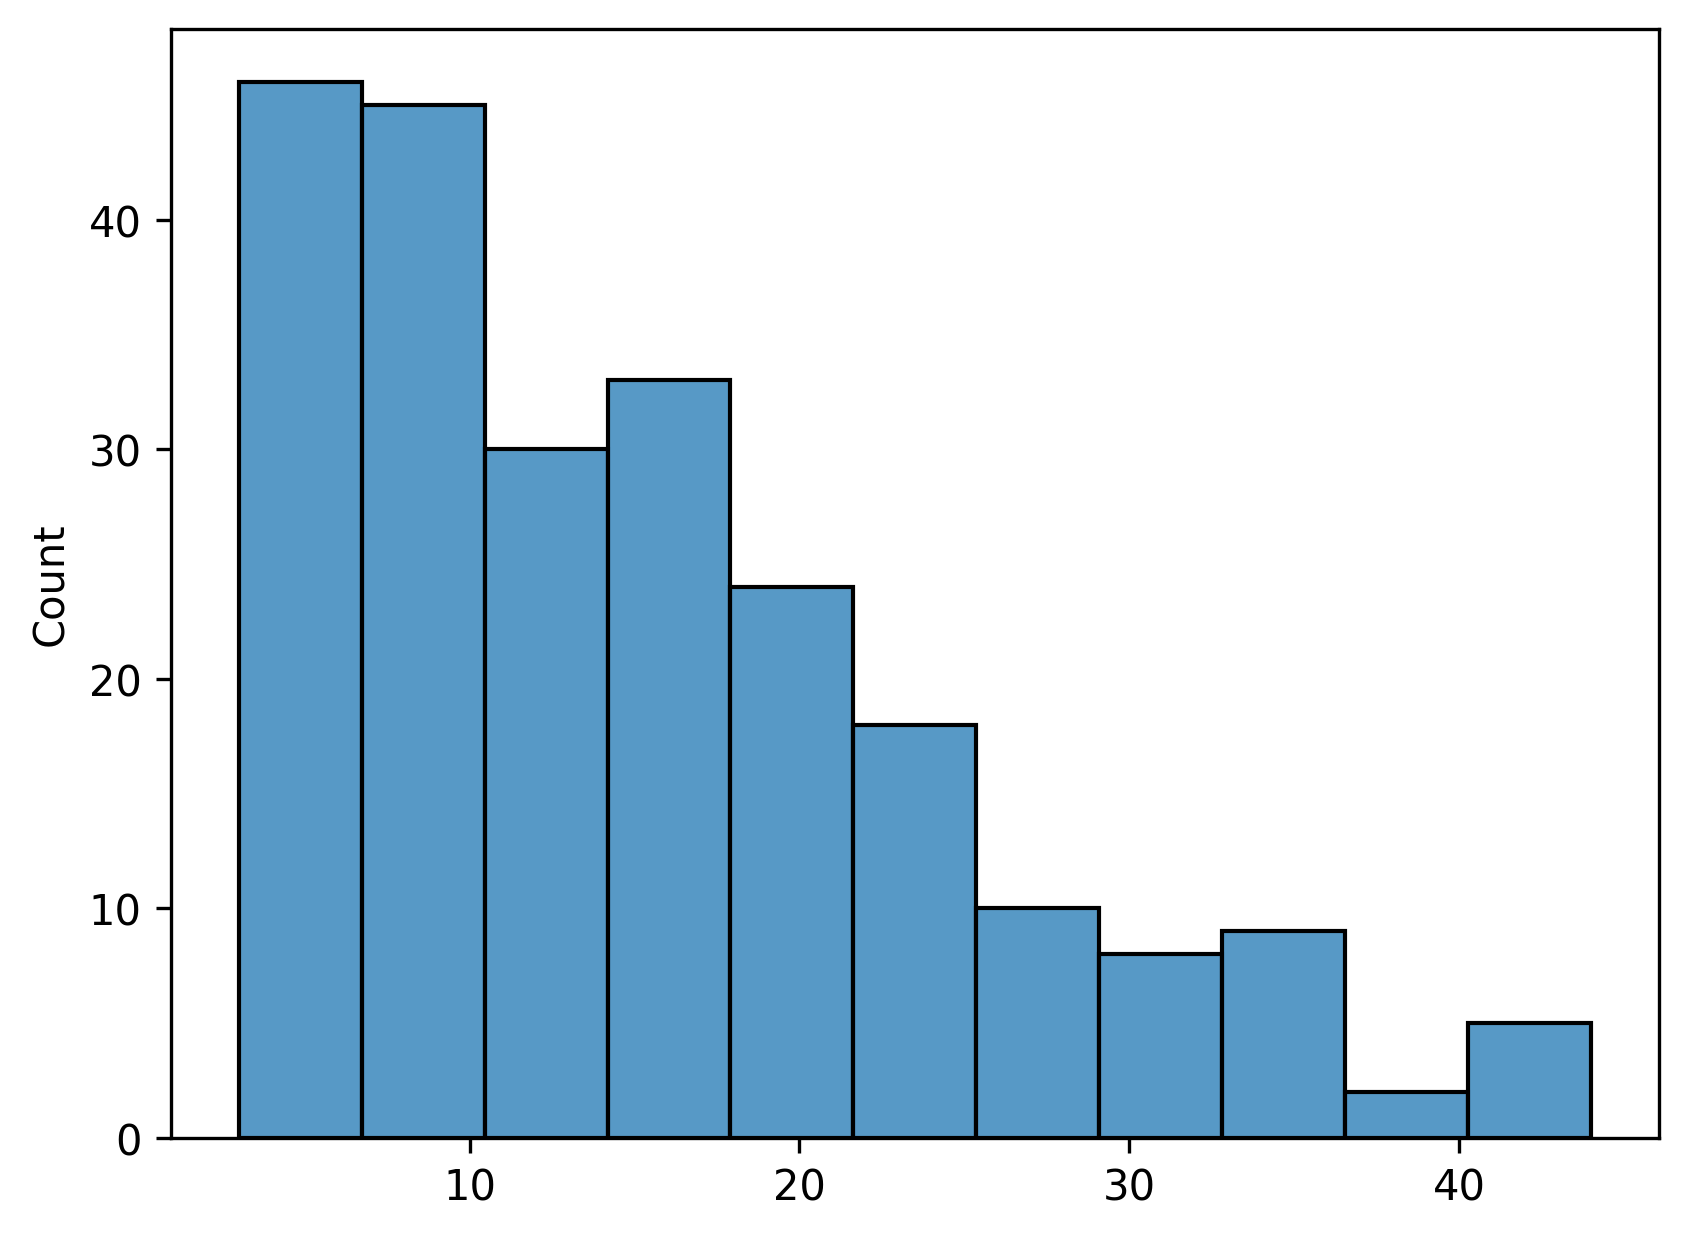

In [68]:
sns.histplot(np.isfinite(K).sum(0))

In [69]:
nK = np.isfinite(K).sum(0)
dp = pd.DataFrame(nK[nK>27])
dp['Gene'] = dp.index
dp['Number of drugs for which this was a target in Kinobeads'] = dp[0]

(20.0, 45.0)

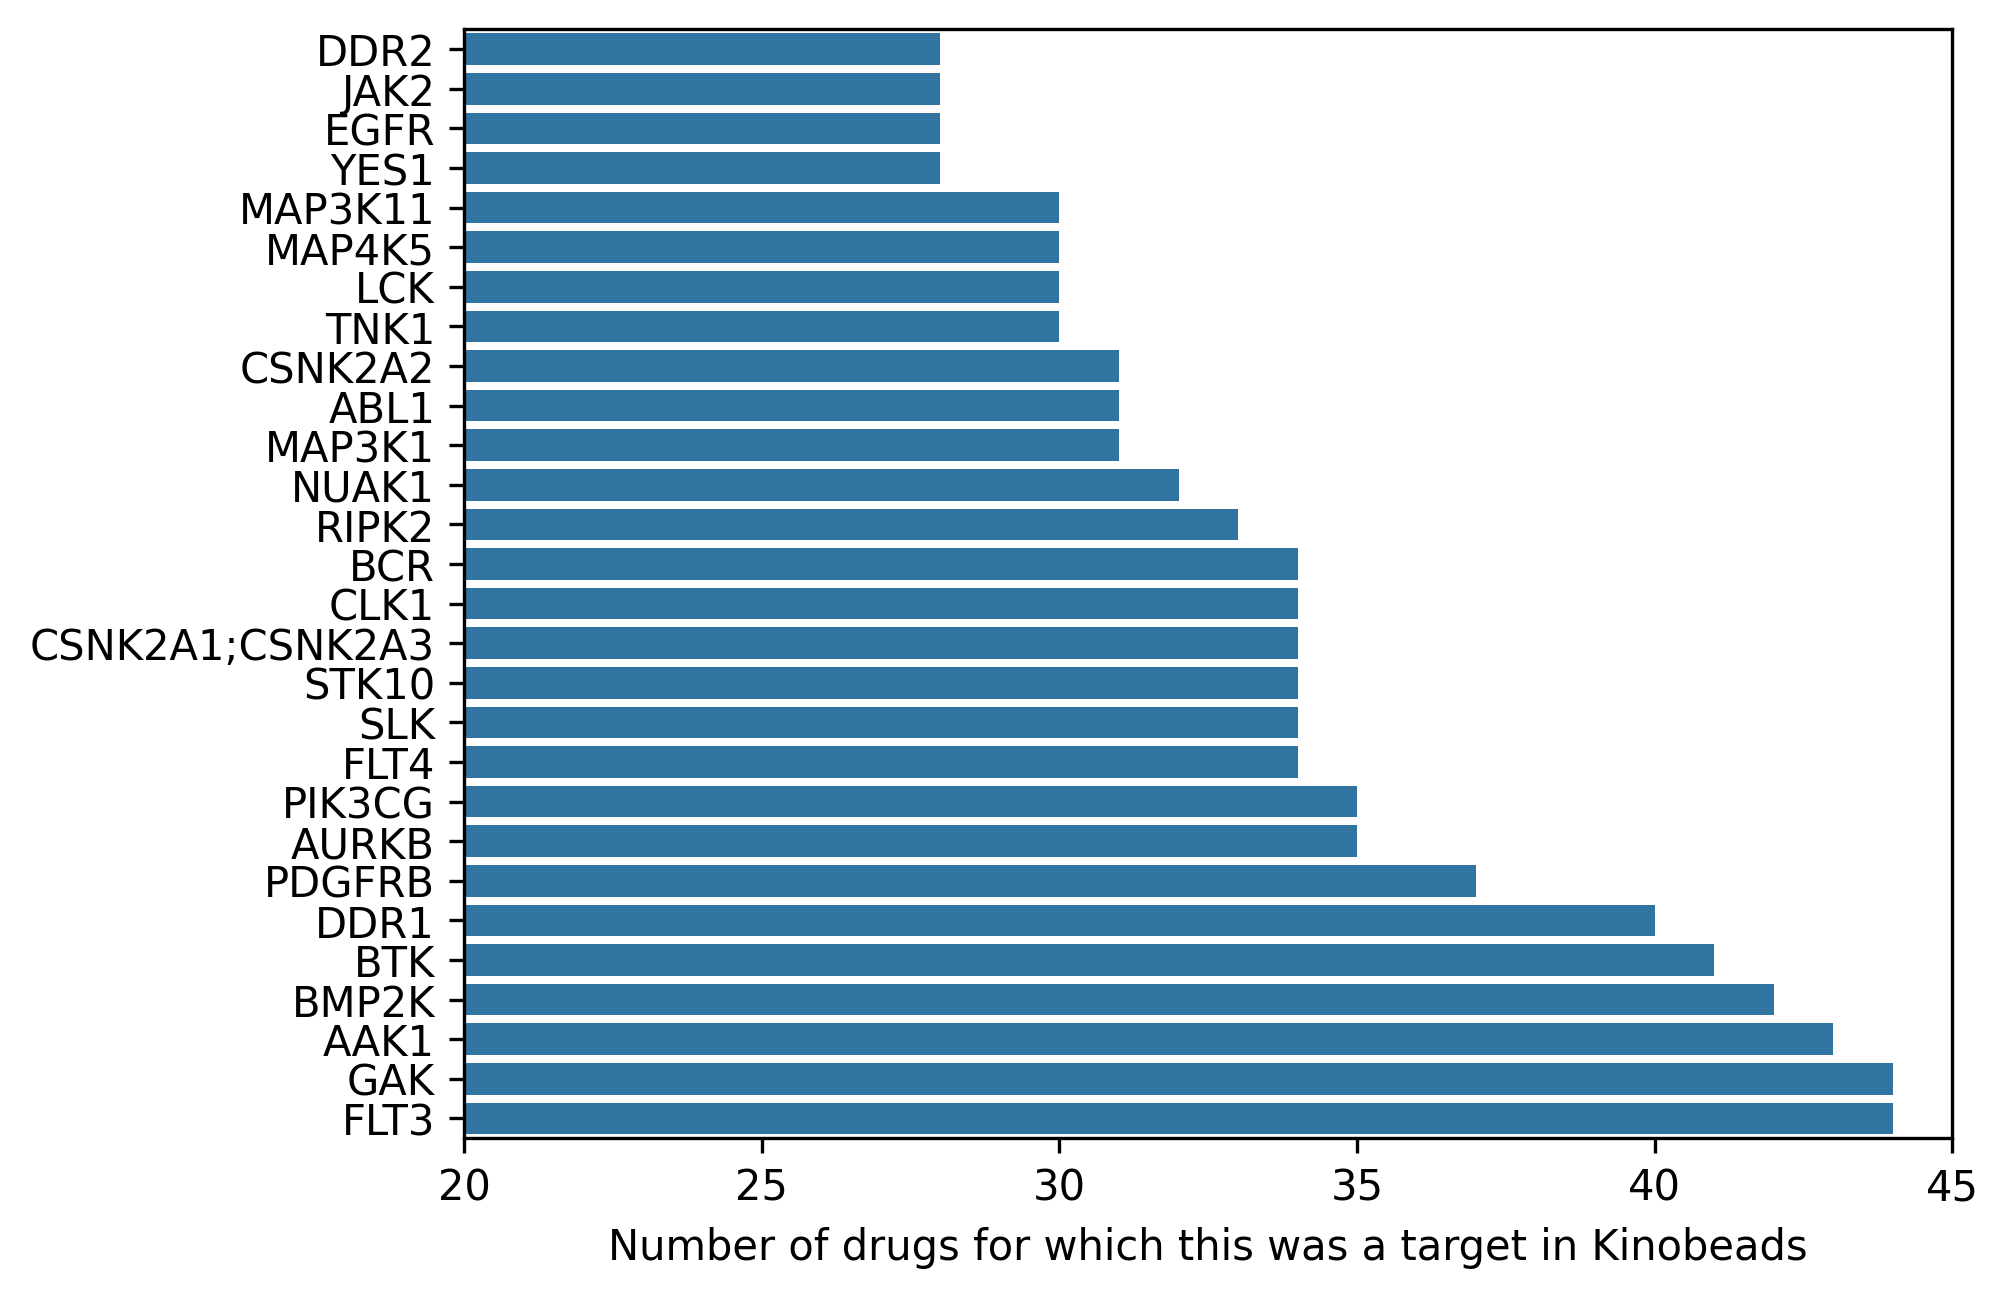

In [70]:
plt.rcParams['figure.dpi'] = 300
sns.barplot(data=dp.sort_values(0), x='Number of drugs for which this was a target in Kinobeads', y='Gene')
plt.ylabel('')
plt.xlim(20,45)

In [82]:
len(dp)

28

In [56]:
K

Gene,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,ADCK1,AKT3,ARAF,...,TNK2,TP53RK,TTK,TTN,TYK2,ULK1,ULK3,WEE1,YES1,ZAK
Pubchem_CID,,,,,,,,,,,,,,,,,,,,,
10029385,7.247534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10427712,4.966414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.036551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11539025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11625818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11647372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90116675,NaN,5.195523,5.372569,NaN,NaN,NaN,NaN,NaN,NaN,6.422851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.592019,6.841364
91667513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91754527,NaN,4.441650,4.438109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='Count'>

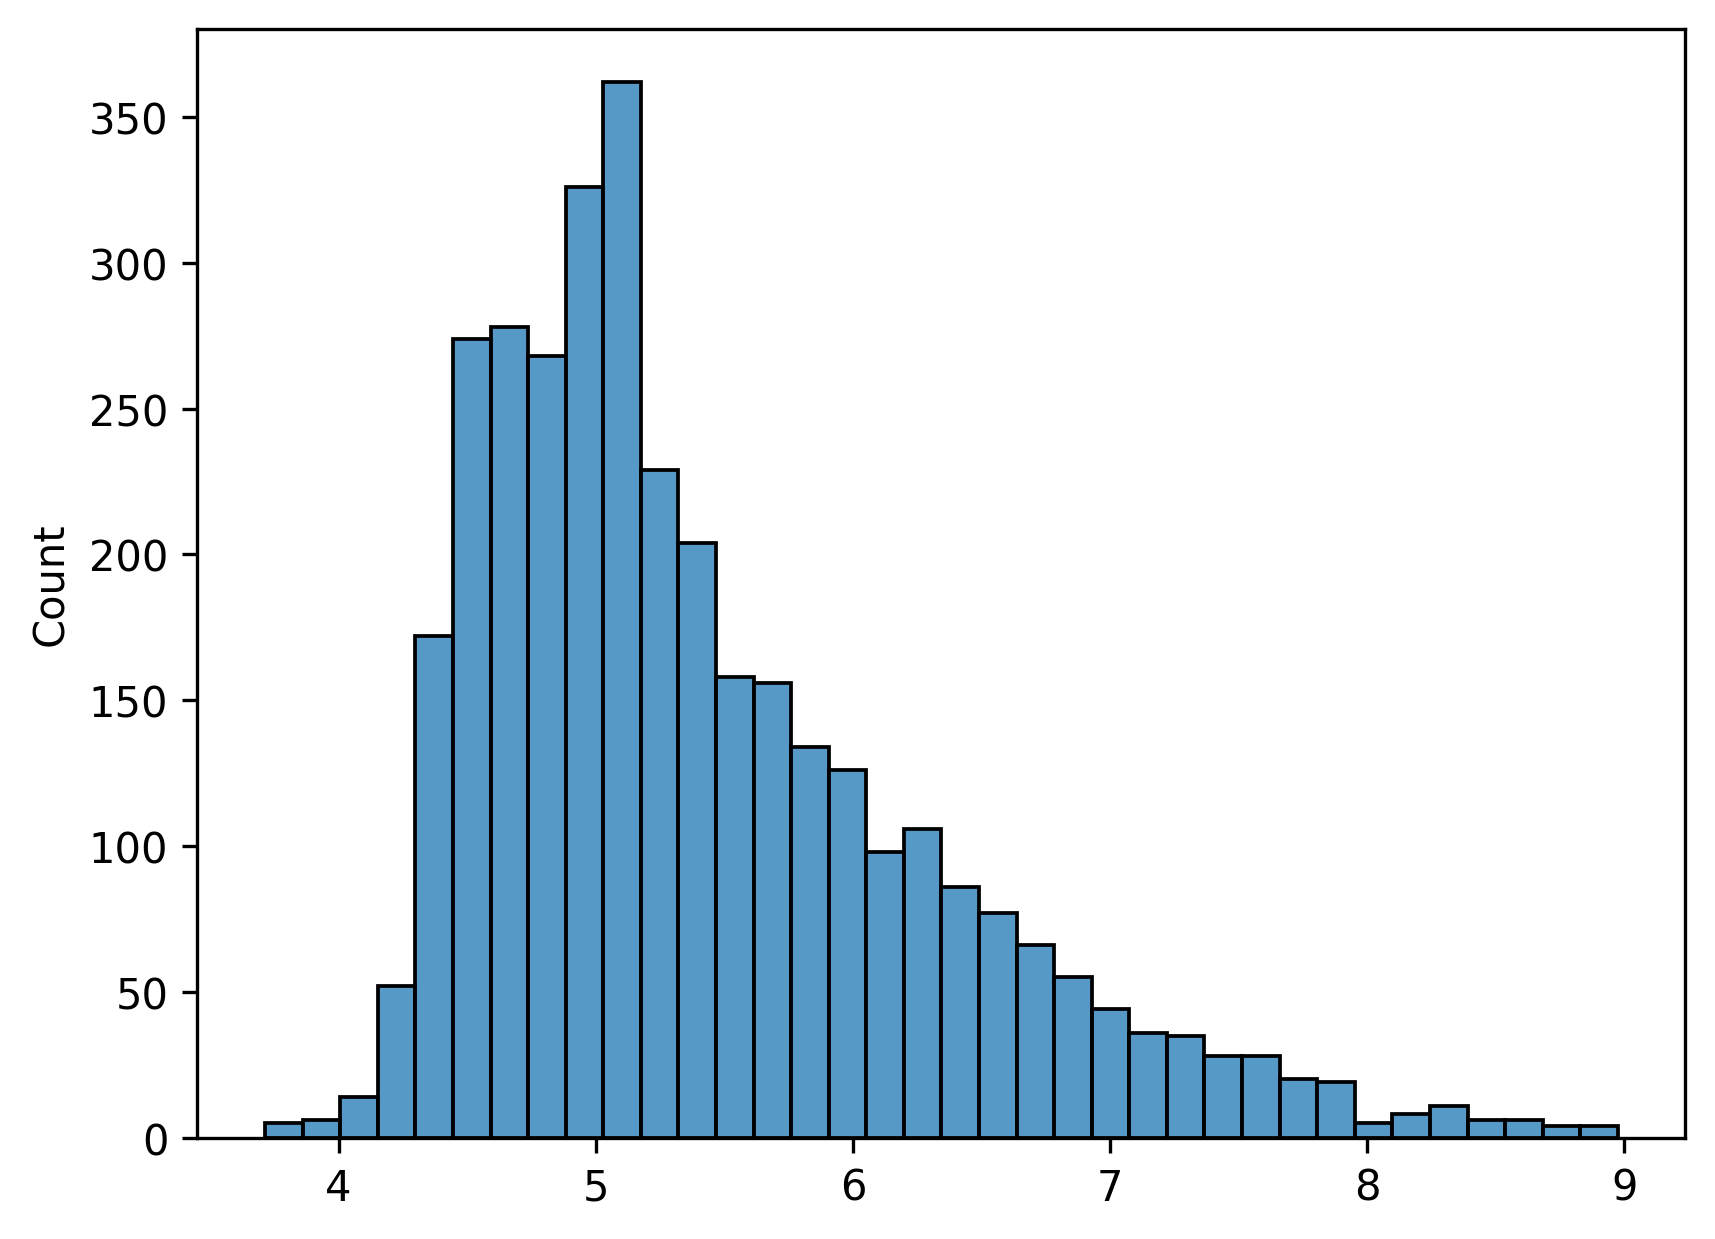

In [73]:
sns.histplot(K.values.flatten())

In [57]:
# Scale the pEC50s such that a pEC50 of max dose is 0, which is 10,000nM (for most drugs, some curves are
# also only to 3,000 and some are to 30,000, but 10**4 should be fine)
# 10,000 nM is pEC50 of -2, hence shift everything by -2

In [58]:
K = (K-2).copy()
K = K.fillna(0)

In [74]:
K

Gene,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,ADCK1,AKT3,ARAF,...,TNK2,TP53RK,TTK,TTN,TYK2,ULK1,ULK3,WEE1,YES1,ZAK
Pubchem_CID,,,,,,,,,,,,,,,,,,,,,
10029385,7.247534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10427712,4.966414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.036551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11539025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11625818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11647372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90116675,NaN,5.195523,5.372569,NaN,NaN,NaN,NaN,NaN,NaN,6.422851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.592019,6.841364
91667513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91754527,NaN,4.441650,4.438109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# And rdkit

In [76]:
from scipy.stats import zscore

# Pubchem-ids to smiles
cid_df = pd.DataFrame(list(K.index))
cid_df.index = K.index
del cid_df[0]
cid_df.to_csv('cids.txt', header=None)
df_cid_to_smiles = pd.read_csv('4421697790156363595-Copy1.txt', sep='\t', header=None)
df_cid_to_smiles[1] = df_cid_to_smiles[1].astype('str')
D_cid_to_smiles = dict(zip(df_cid_to_smiles[0], df_cid_to_smiles[1]))
D_cid_to_smiles_inv = dict(zip(df_cid_to_smiles[1], df_cid_to_smiles[0]))

In [77]:
smiles_list = list(df_cid_to_smiles[1])
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
generator = MakeGenerator(("RDKit2D",))
rdk_emb = [generator.process(a) for a in smiles_list]
rdk_emb = [a[1:] if a!=None else 'a' for a in rdk_emb]

In [78]:
# cap values to abs 10**2
Xrdk = np.vstack(rdk_emb)
Xrdk[Xrdk>10**2]=10**2
Xrdk[Xrdk<-10**2]=-10**2
Zrdk = pd.DataFrame(data=Xrdk, index=df_cid_to_smiles[0])

In [79]:
Zrdk = pd.DataFrame(data=Xrdk, index=df_cid_to_smiles[0])

In [80]:
Zrdk

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,,,,,,,,,,,,,,,,,,,,,
10029385,1.368748e+00,100.0,25.965526,20.614434,20.614434,18.491204,12.873010,12.873010,10.054613,10.054613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.416922
10427712,2.081441e+00,100.0,18.258784,13.456784,13.456784,12.508040,7.706153,7.706153,5.660737,5.660737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.432665
11539025,1.912179e+00,100.0,22.551677,18.915378,18.915378,14.420653,10.418344,10.418344,10.221942,10.221942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454719
11625818,1.737844e+00,100.0,21.371668,16.580240,16.580240,15.169035,9.842638,9.842638,7.008666,7.008666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453318
11647372,1.671524e+00,100.0,20.501425,16.246526,16.246526,14.703510,9.878961,9.878961,7.029075,7.029075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90116675,1.334162e+00,100.0,26.603719,19.787427,20.603924,18.208347,11.951289,13.391352,9.390847,11.061502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339332
91667513,1.567022e+00,100.0,22.501425,17.737610,17.737610,15.546045,10.603277,10.603277,7.739711,7.739711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.585764
91754527,4.486070e-07,100.0,34.001060,26.973478,26.973478,23.048920,15.821964,15.821964,12.543693,12.543693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.182612


In [ ]:
sns.heatmap(Zrdk)

In [ ]:
Zd

In [ ]:
K

In [ ]:
Zrdk

In [ ]:
# Do a 10-dim PCA for Kinobeads and rdKit

In [ ]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(K)
transformed_arrays = pca.transform(K)
K2 = pd.DataFrame(data=transformed_arrays, index=K.index)

In [ ]:
sns.heatmap(K2)

In [ ]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(Zrdk)
transformed_arrays = pca.transform(Zrdk)
Zrdk2 = pd.DataFrame(data=transformed_arrays, index=K.index)

In [ ]:
sns.heatmap(Zrdk2)

In [ ]:
# Save all the embeddings
Zd.to_pickle(f'{dataset}_ALS_drug_embedding.pkl')
K2.to_pickle(f'{dataset}_Kinobead_drug_embedding.pkl')
Zrdk2.to_pickle(f'{dataset}_rdkit_drug_embedding.pkl')

In [ ]:
dfv_train = dfv[dfv['Cello'].isin(train_ccls)].copy()
dfv_test = dfv[dfv['Cello'].isin(test_ccls)].copy()
# pickle it 
dfv_train.to_pickle(f'{dataset}_dfv_train.pkl')
dfv_test.to_pickle(f'{dataset}_dfv_test.pkl')

In [ ]:
dataset